## Transient Simulations 
*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [13]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os
import time
import csv
import seaborn as sns
from pyDOE import *
import random
#additional analysis tools
import flopy.utils.binaryfile as bf
from flopy.utils.sfroutputfile import SfrFile

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
np.set_printoptions(threshold=np.inf)


moddir="C:/WRDAPP/MF2005.1_12/bin/mf2005.exe"
modws ="C:/Users/davem/Documents/Thesis/modflow/mfoutput"
modws= "D:/mfoutput/transientSeasons"


#jupyter specific--included to show plots in notebook
%matplotlib inline 

## 2. Discretization and other inputs

In [2]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

width = 100
dx= width #width of grid cells in x direction 
dy= width #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

#ztop = 100
ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)

## Subsurface properties - These get overwritten in the run code cell
#K_horiz = 1.    #horizontal hydraulic conductivity 
#K_vert = 1.    #assign vertical hydraulic conductivity (along z axis)
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
ET = 1e-5 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
rip_ET= 10e-5  #riparian zone
rip_locxy= [[0,21000],[23000,0]]
extinction_depth = 10 #m

ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (25.0, 49.0)

ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 


rip_rows_forced = (22.0, 29.0)  #forced riparian area
rip_cols_forced = (1.0, 49.0)

ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 

Rip_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
Rip_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 

## Recharge
rech=5e-5  #m/d


rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
rech_cols_forced = (1.0, 10.0)

rech_zone_forced = np.zeros((1,nrow,ncol))
rech_zone_forced[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech


print(ztop[25])

[100.   99.   98.   97.   96.   95.   94.   93.   92.   91.   90.   89.
  88.   87.   86.   85.   84.   83.   82.   81.   80.   79.   78.   77.
  76.   75.9  75.8  75.7  75.6  75.5  75.4  75.3  75.2  75.1  75.   74.9
  74.8  74.7  74.6  74.5  74.4  74.3  74.2  74.1  74.   73.9  73.8  73.7
  73.6  73.5]


In [3]:
sp_peryr = 2   #number of seasons (with and wihtout ET. April-Sept and Oct-Mar)
sp1_len = 180  #sp lengths
sp2_len = 180
sim_years = 20
nper = int(sp_peryr*sim_years + 1)

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False     # steady-state or transient flag for each stress period (boolean array)
#print(steady)
steady[0] = True    # initial stress period is steady-state

#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)
perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation
print("Period lengths", perlen)

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 
#so we can repeat the perlen array - actually we are doing it every 6 days to save computation time
nstp=perlen/6 # Silghtly less than weekly 
nstp[0]=1 #for the steady state solution we just want one output
nstp = nstp.astype(int)
print("Number of Steps", nstp)

#Irrigation well

#Aqua Seca Well well
pumping = -1000 #m3/day 
SteadyPump = -250 #might want to increase the seasonal pumping
well_row =   19 #12
well_col =   32 #14
well_loc = (2,well_row, well_col)
well = [2,well_row, well_col, pumping] 


well_val = np.tile([1,0],sim_years)
well_val = np.append(0,well_val)
wel_spd =  {1: [2,well_row, well_col, 0]}
#ET_val=np.tile([1, 0],sim_years)
#ET_val=np.append(sampling[i][4]/2,ET_val) #add on steady state period at beginning with 1/2 the ET 
for p in range(0, nper):   
    #pumping = 0
    wel_spd[p+1] =  [2,well_row, well_col, pumping*well_val[p]]

# #Steady Pumping rate Transient
# wel_spdst =  {0: [2,well_row, well_col, 0]}
# well_val = np.tile([1,1],sim_years+1)
# for p in range(1, nper):   
#     #pumping = 0
#     wel_spdst[p] =  [2,well_row, well_col, SteadyPump*well_val[p]]
    
print(wel_spd)


Period lengths [ 10 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180]
Number of Steps [ 1 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30]
{1: [2, 19, 32, 0], 2: [2, 19, 32, -1000], 3: [2, 19, 32, 0], 4: [2, 19, 32, -1000], 5: [2, 19, 32, 0], 6: [2, 19, 32, -1000], 7: [2, 19, 32, 0], 8: [2, 19, 32, -1000], 9: [2, 19, 32, 0], 10: [2, 19, 32, -1000], 11: [2, 19, 32, 0], 12: [2, 19, 32, -1000], 13: [2, 19, 32, 0], 14: [2, 19, 32, -1000], 15: [2, 19, 32, 0], 16: [2, 19, 32, -1000], 17: [2, 19, 32, 0], 18: [2, 19, 32, -1000], 19: [2, 19, 32, 0], 20: [2, 19, 32, -1000], 21: [2, 19, 32, 0], 22: [2, 19, 32, -1000], 23: [2, 19, 32, 0], 24: [2, 19, 32, -1000], 25: [2, 19, 32, 0], 26: [2, 19, 32, -1000], 27: [2, 19, 32, 0], 28: [2, 19, 32, -1000], 29: [2, 19, 32, 0], 30: [2, 19, 32, -1000], 31: [2, 19, 32, 0], 32:

### Layering

In [4]:
## define layer properties 
K_horiz = 10 #m/d
K_vert = 10 #m/d
K_vert2 = 0.0001 #m/d  #K for the middle layer 


## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array

## Made some changes to the thickness
bot_elev = 0. #0
mid_elev = 40. #40
top_elev = 45. #45

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 


## Boundary Conditions

In [5]:
#original BCS

#print(ibound)
#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0

## Right Boundary condition
h_right = 62 #was 70

H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value

#########################
#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,0,49]=0
ibound[:,49,49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

#new bottom no flow zone constriction
ibound[:,1,19:]=0
ibound[:,2,25:]=0
ibound[:,3,30:]=0
ibound[:,4,33:]=0
ibound[:,5,36:]=0
ibound[:,6,39:]=0
ibound[:,7,41:]=0
ibound[:,8,43:]=0
ibound[:,9,45:]=0
ibound[:,10,46:]=0
ibound[:,11,47:]=0
ibound[:,12,48:]=0

ibound[:,48,19:]=0
ibound[:,47,25:]=0
ibound[:,46,30:]=0
ibound[:,45,33:]=0
ibound[:,44,36:]=0
ibound[:,43,39:]=0
ibound[:,42,41:]=0
ibound[:,41,43:]=0
ibound[:,40,45:]=0
ibound[:,39,46:]=0
ibound[:,38,47:]=0
ibound[:,37,48:]=0

#np.savetxt("ibound_lyr1.txt", ibound[0])

## Stream with SFR2 Package

In [6]:
#SFR package inputs

reach = np.recarray((nrow,), dtype=[('k', '<f8'), ('i', '<f8'), ('j', '<f8'), ('iseg', '<f8'), ('ireach', '<f8'), ('rchlen', '<f8'),('strtop', '<f4')])

reach[:][:] = 0.0 # zero it out
#reach['k'][:] = 0 #testing
reach['i'][:] = ncol/2   #set it to the middle row
reach['j'][:] = [i for i in range(nrow)] #all columns in the middle row
reach['iseg'][:] = 1 #segment number - we only have 1 so all cells - segment number starts with 1!
#reach['iseg'][25:] = 2
reach['ireach'][:50] = [i for i in range(1,51)] #number the 50 reaches - starts with 1!
#reach['ireach'][25:] = [i for i in range(1,26)]
reach['rchlen'][:] = dx
reach['strtop'][:] = ztop[25]-5 #Sets the stream elevation to below the top of the top layer cells 
#print(ztop)

#Segment Data
dtype = flopy.modflow.ModflowSfr2.get_default_segment_dtype() #get the correct datatypes for the segments
indices = ['nseg','width1','width2','icalc','roughch','flow','outseg','iupseg','hcond1','hcond2','thickm1','thickm2','etsw','pptsw','elevup','elevdn']

seg_data = np.recarray((1,), dtype[indices])
seg_data[:] = 0
seg_data['width1'] = 5 #Upstream width
seg_data['width2'] = 10 #downstream width
seg_data['icalc'] = 1 #Stream depth calculated every stress period - assumes wide rectangular channel - uses Manning's equation
seg_data['nseg'] = 1 #segment number
seg_data['roughch'] = 0.035 #Manning's n 
seg_data['flow'] = 1 #initial inflow at first reach in segment
seg_data['hcond1'] = 0.0001 #K - also set in the run cell as it is one of the parameters that is varied
seg_data['hcond2'] = 0.0001 
seg_data['thickm1'] = 2  #Stream bed thickness
seg_data['thickm2'] = 2  
seg_data['elevup'] = reach['strtop'][0]   #elevation at start added reach strtop for transeint was 100 and 70 for eleveldn
seg_data['elevdn'] = reach['strtop'][-1]
seg_data['etsw'] = 0  #Stream channel ET
seg_data['pptsw'] = 0 #Stream channel precip

segment_data = seg_data

nstrm = -len(reach)  # number of reaches - negative for transient!
nss = 1 #len(seg_data[0])  # number of segments
nsfrpar = 0  # number of parameters (not supported)
nparseg = 0
const = 1.0  # constant for manning's equation, units of cfs
dleak = 0.01  # closure tolerance for stream stage computation
ipakcb = 53  # flag for writing SFR output to cell-by-cell budget (on unit 53)
istcb2 = 81  # flag for writing SFR output to text file

dataset_5 = {0:[nss, 0, 0]}  # dataset 5 (see online guide) - first one must be equal to number of segments 

for i in range(1,nper):
    dataset_5[i] = [0, 0, 0] #one for every stress period, first number must be less than number of segments (except first stress period) (for some reason)


irtflg = 1 #flag for routng with kinematic wave, if so desired, uses defaults for other routing params



In [7]:
##Only going to use the simulations that worked for the Drawdown Situation to save space and time computing

error_list = np.loadtxt('ErrorSteadyPump_Sfr750Test.txt')
sampling = np.loadtxt("ModflowParams7-750Test12.txt")
n = np.arange(0,len(sampling))

#print(error_list[:,0])
n2 = np.setdiff1d(n, error_list[:,0].astype('int'))
#print(len(n2))
#print(n2)

## create packages and run model

In [14]:
#create model object

#load in the parameter sampling from text - so it's the same everytime
#sampling = np.loadtxt("ModflowParams7-750Test12.txt")
#n = len(sampling)#np.loadtxt('TransSamples.txt').astype('int')
error_list = []

#using list of working simulations from drawdown - n2 in previous code block 
for i in n2:
    t0 = time.time()
    #print(sampling[i])
    #modelname = "ScenarioSfr750Seasons_"+str(i)
    modelname = "ScenarioSfr750SeasonsTest_"+str(i)
    m = flopy.modflow.Modflow(modelname,model_ws = modws, exe_name = moddir)

    #Discretization - dis
    dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady,perlen=perlen, nstp=nstp)

    # Boundary and initial conditions - bas
    bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

    #Layer properties - lpf
    ## make horizontal K np arrays
    #Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
    Kh[:,:,:] = sampling[i][0] # assign the original value to the entire array

    ## Make a arrays for the K values
    #Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
    Kz[:,:,:] = sampling[i][0] #* sampling[i][7]                # assign the original value to the entire array
    
    #restrictive layer
    Kz[1,:,10:49] = sampling[i][0] * sampling[i][1] #* sampling[i][7]       #Replace K in the middle layer with the lower value
    Kh[1,:,10:49] = sampling[i][0] * sampling[i][1]     
    #changed to 10 for start of restrictive layer
    
    Sy = sampling[i][2]
    
    lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, #laywet = [1,1,1],
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)
    
    #Setting up ET stress periods   
    ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = sampling[i][4]
    ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = (sampling[i][4] * sampling[i][5])
    
    ET_val=np.tile([1, 0],sim_years)
    ET_val=np.append(1/2,ET_val) #add on steady state period at beginning with 1/2 the ET 
    
    ET = {} #ET Stress period dictionary
    for p in range(0,nper):    #loop over stress periods
        #print(ET_val[p])        
        ET[p+1]=ET_zone*ET_val[p] 
    
    evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53)
    #evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) #no seasonality


    #Recharge - rch
    rech_zone_forced[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=sampling[i][3]
      
    rch = flopy.modflow.mfrch.ModflowRch(model=m, nrchop=3, rech=rech_zone_forced, ipakcb=53)     #create rch object

    #SFR2 
    seg_data['hcond1'] = seg_data['hcond2'] = sampling[i][6]
    
    sfr = flopy.modflow.ModflowSfr2(
        model = m,
        nstrm=nstrm,
        nss=nss,
        const=const,
        dleak=dleak,
        ipakcb=ipakcb,
        #istcb1 = 81,
        istcb2=istcb2,
        reach_data=reach,
        segment_data=seg_data,
        #channel_geometry_data=channel_geometry_data,
        #channel_flow_data=channel_flow_data,
        dataset_5=dataset_5,
        #unit_number=15,
        irtflg = irtflg,
        numtim = 2,
        flwtol = 0.001,#number of timesteps to compute for routing
        transroute = True
    )
    sfr.assign_layers(adjust_botms=True, pad=1.0) #I haven't figure out yet why the Transient version has issues with the channel bottom - but this fixes it by offsetting by -1 if there is an issue
    #print(sfr.reach_data)
    
    #Well - wel
    wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd) #Seasonal pumping
   # wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spdst) #steady pumping lower rate

    #Output control - OC 

    oc_spd = {}
    for kper in range(nper):
        for kstp in range(nstp[kper]):
            #print(kstp)
            oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']
   # spd = {(-1, -1): [],
     #   (0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
    oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

    #Numerical solver - pcg
    pcg = flopy.modflow.ModflowPcg(model=m, 
                               mxiter=100, iter1=200, 
                               relax = 0.97,
                               damp = 0.7
                              )
    #chk = sfr.check()
#     wel.check()
#     pcg.check()
#     m.check()
#     oc.check()
#     evt.check()
#     rch.check()
#     lpf.check()
#     bas.check()
    #write the inputs
    #sfr.plot(key='iseg')
    m.write_input()   
    
    #Run the model 
    success, mfoutput = m.run_model(pause=False, report=False, silent=True)
    
    t1 = time.time()
    tt = t1-t0
    if not success:
        #raise Exception('MODFLOW did not terminate normally.')      
        print('MODFLOW did not terminate normally. Parameters saved to file. Time: ' + str(tt))
        #save parameters        
        error_list.append(np.hstack((np.array(i),sampling[i])))
        #leakage_array[i] = -1
    else:
        print("Simulation " + str(i) + " Terminated Normally. Time: " + str(tt))
#         #older format that saves the output at the end stream reach cell for easier use in the Decision Tree 
#         #now I just grab all the data seperately in the Tree Notebook
#         sfrout = SfrFile(modws+'/'+ modelname+'.sfr.out') 
#         df = sfrout.get_dataframe()
#         leakage_array[i] = df.Qout[49]

if error_list:
    #np.savetxt("ErrorSeasons_Sfr750.txt", error_list)
    np.savetxt("ErrorSeasons_Sfr750Test.txt", error_list)

    print(len(error_list), " simulations did not terminate normally.")

Simulation 1 Terminated Normally. Time: 98.1353051662445
Simulation 2 Terminated Normally. Time: 114.0017499923706
Simulation 3 Terminated Normally. Time: 92.82476496696472
Simulation 4 Terminated Normally. Time: 78.30565547943115
Simulation 6 Terminated Normally. Time: 146.13541388511658
Simulation 7 Terminated Normally. Time: 99.02372455596924
Simulation 8 Terminated Normally. Time: 83.31946778297424
Simulation 9 Terminated Normally. Time: 164.02080273628235
Simulation 10 Terminated Normally. Time: 103.32131028175354
Simulation 11 Terminated Normally. Time: 134.02917790412903
MODFLOW did not terminate normally. Parameters saved to file. Time: 100.02710103988647
MODFLOW did not terminate normally. Parameters saved to file. Time: 2.3909900188446045
Simulation 14 Terminated Normally. Time: 139.61762928962708
Simulation 15 Terminated Normally. Time: 96.3069577217102
Simulation 16 Terminated Normally. Time: 86.36743354797363
MODFLOW did not terminate normally. Parameters saved to file. Ti

Simulation 163 Terminated Normally. Time: 139.56247878074646
Simulation 164 Terminated Normally. Time: 97.69742488861084
Simulation 165 Terminated Normally. Time: 105.28136444091797
MODFLOW did not terminate normally. Parameters saved to file. Time: 43.501301527023315
Simulation 168 Terminated Normally. Time: 153.66327357292175
Simulation 170 Terminated Normally. Time: 82.20930981636047
MODFLOW did not terminate normally. Parameters saved to file. Time: 71.30967974662781
Simulation 174 Terminated Normally. Time: 122.69353222846985
Simulation 175 Terminated Normally. Time: 101.89441657066345
Simulation 176 Terminated Normally. Time: 94.07844948768616
Simulation 178 Terminated Normally. Time: 137.1628909111023
MODFLOW did not terminate normally. Parameters saved to file. Time: 3.1087534427642822
MODFLOW did not terminate normally. Parameters saved to file. Time: 14.176944255828857
MODFLOW did not terminate normally. Parameters saved to file. Time: 74.4093906879425
MODFLOW did not termina

MODFLOW did not terminate normally. Parameters saved to file. Time: 67.87779664993286
Simulation 313 Terminated Normally. Time: 127.42057275772095
Simulation 315 Terminated Normally. Time: 132.45449304580688
MODFLOW did not terminate normally. Parameters saved to file. Time: 2.418133497238159
Simulation 318 Terminated Normally. Time: 81.1073591709137
Simulation 319 Terminated Normally. Time: 100.05562210083008
MODFLOW did not terminate normally. Parameters saved to file. Time: 3.0110676288604736
MODFLOW did not terminate normally. Parameters saved to file. Time: 17.475934982299805
MODFLOW did not terminate normally. Parameters saved to file. Time: 2.4678421020507812
MODFLOW did not terminate normally. Parameters saved to file. Time: 12.780948638916016
Simulation 326 Terminated Normally. Time: 79.23812556266785
Simulation 327 Terminated Normally. Time: 117.38956952095032
Simulation 328 Terminated Normally. Time: 148.7291316986084
MODFLOW did not terminate normally. Parameters saved to f

Simulation 460 Terminated Normally. Time: 86.6428279876709
Simulation 462 Terminated Normally. Time: 106.5527126789093
Simulation 463 Terminated Normally. Time: 89.64719676971436
MODFLOW did not terminate normally. Parameters saved to file. Time: 8.540534734725952
Simulation 465 Terminated Normally. Time: 147.11597776412964
Simulation 466 Terminated Normally. Time: 77.40497255325317
Simulation 467 Terminated Normally. Time: 108.04399490356445
MODFLOW did not terminate normally. Parameters saved to file. Time: 94.29314041137695
Simulation 469 Terminated Normally. Time: 96.355388879776
Simulation 470 Terminated Normally. Time: 92.45755696296692
Simulation 471 Terminated Normally. Time: 118.69380497932434
Simulation 472 Terminated Normally. Time: 104.92216658592224
Simulation 473 Terminated Normally. Time: 101.46288299560547
Simulation 475 Terminated Normally. Time: 133.60601329803467
Simulation 476 Terminated Normally. Time: 86.64725065231323
Simulation 477 Terminated Normally. Time: 93.

Simulation 612 Terminated Normally. Time: 106.20203256607056
Simulation 613 Terminated Normally. Time: 129.10503602027893
MODFLOW did not terminate normally. Parameters saved to file. Time: 90.05294036865234
Simulation 615 Terminated Normally. Time: 98.7125973701477
MODFLOW did not terminate normally. Parameters saved to file. Time: 18.790405988693237
Simulation 617 Terminated Normally. Time: 95.43604636192322
Simulation 618 Terminated Normally. Time: 106.7329523563385
Simulation 619 Terminated Normally. Time: 104.93084383010864
Simulation 621 Terminated Normally. Time: 146.91603565216064
MODFLOW did not terminate normally. Parameters saved to file. Time: 92.92164850234985
MODFLOW did not terminate normally. Parameters saved to file. Time: 25.898940563201904
Simulation 625 Terminated Normally. Time: 147.39014792442322
Simulation 626 Terminated Normally. Time: 115.01481795310974
Simulation 627 Terminated Normally. Time: 87.21230411529541
Simulation 628 Terminated Normally. Time: 84.1622

## Looking at the SFR Output

In [14]:
#print(sfr.reach_data)
#print(error_list)


modelname = "ScenarioSfr750SeasonsTest_"+str(1)
sfrout = SfrFile(modws+'/'+modelname+'.sfr.out')
df = sfrout.get_dataframe()
df.reset_index(drop = True, inplace = True) #FOr some reason the index seems to be off number wise so this helps


# Trying to figure out why the kstp and kper are all 0s - could just back the info out from the index number though
#times = sfrout.get_times() 
#df['kstpkper'] = times

#Backing out the stress period from the rows
#should be 50 rows for the first stress period (1 timestep for each reach), then 1500 (50*30) for the remaining 20 stressperiods for a total of 30050 timesteps (rows)
df['Stp']= 1
df.iloc[50:,-1] = (np.divmod(np.arange(len(df)-50),50*30*2)[0]+1)+1

print(df[df['Stp'] == 2])

      layer  row  column  segment  reach       Qin  Qaquifer      Qout  Qovr  \
50        1   26       1        1      1    1.0000    0.0000    1.0000   0.0   
51        1   26       2        1      2    1.0000   -5.1020    6.1358   0.0   
52        1   26       3        1      3    6.1358   -5.5936   11.7850   0.0   
53        1   26       4        1      4   11.7850   -6.1487   17.9850   0.0   
54        1   26       5        1      5   17.9850   -6.6983   24.7510   0.0   
...     ...  ...     ...      ...    ...       ...       ...       ...   ...   
3045      1   26      46        1     46  156.2500   10.2500  146.5100   0.0   
3046      1   26      47        1     47  146.5100   13.3000  133.7200   0.0   
3047      1   26      48        1     48  133.7200   17.8940  116.3300   0.0   
3048      1   26      49        1     49  116.3300   25.4560   91.3690   0.0   
3049      1   26      50        1     50   91.3690    0.0000   91.8390   0.0   

      Qprecip  ...    stage   depth  wi

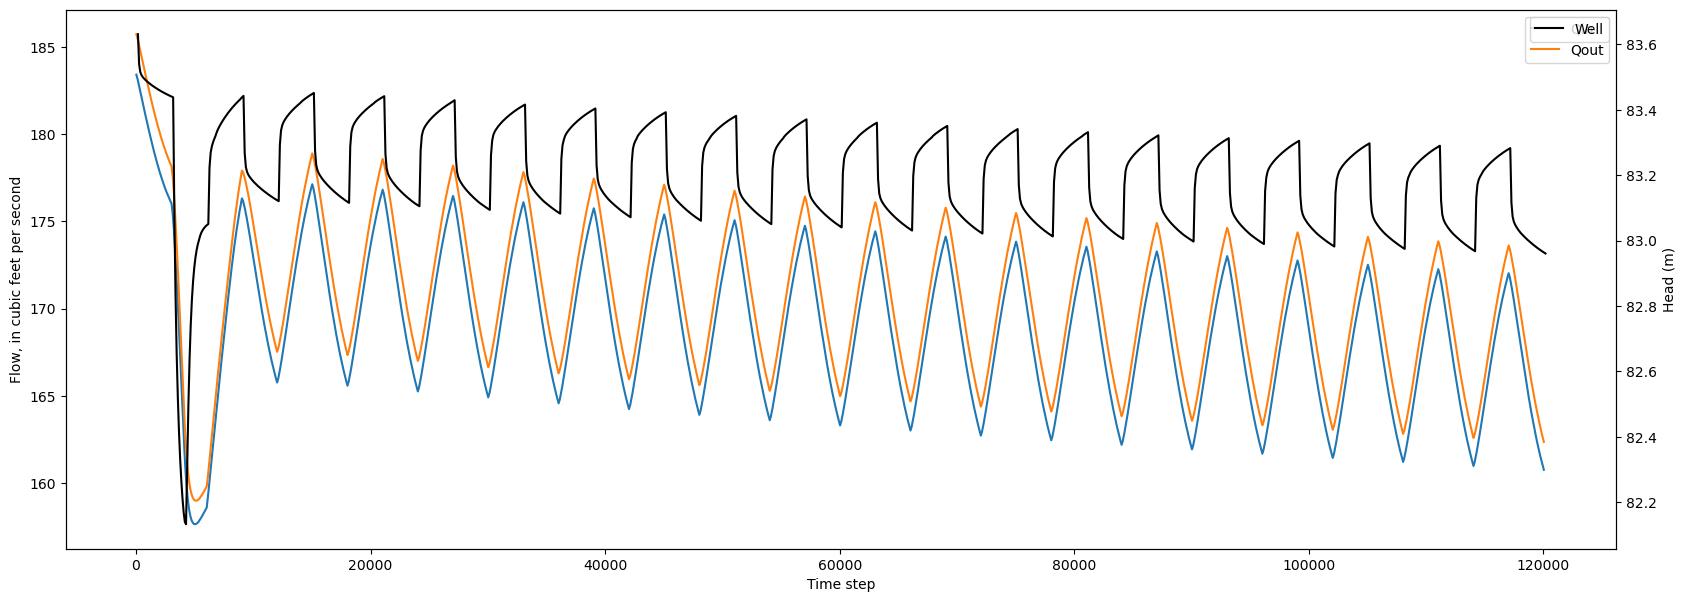

In [17]:
#Plotting out stream Q with head values across all time stepss
#modelname = "ScenarioSfr2500_Trans_1"
n = np.loadtxt('TransSamples.txt').astype('int')
n = [0,1]
modelname = "ScenarioSfr750SeasonsTest_"+str(n[1])
sfrout = SfrFile(modws+'/'+modelname+'.sfr.out')
df = sfrout.get_dataframe()
df.reset_index(drop = False, inplace = True) #FOr some reason the index seems to be off number wise so this helps


# Trying to figure out why the kstp and kper are all 0s - could just back the info out from the index number though
#times = sfrout.get_times() 
#df['kstpkper'] = times

#Backing out the stress period from the rows
#should be 50 rows for the first stress period (1 timestep for each reach), then 1500 (50*30) for the remaining 20 stressperiods for a total of 30050 timesteps (rows)
df['Stp']= 1
df.iloc[50:,-1] = (np.divmod(np.arange(len(df)-50),50*30*2)[0]+1)+1 #Stp is the last col (-1) so the iloc references every row beyond 50 in the last column
#added *2 above for each computation step with kinematic wave routing

#group rows by change in Stp and grab the last Stress period 
Stpdf = df.groupby('Stp').tail(n=50) #groups tthe dataframe by the Stress period then grabs the last 50 rows (reaches) of the stress period representing the last timestep
#print(Stpdf.iloc[50])
#print(df.iloc[50])

inds = df.reach == 32 #grab indices for reach of interest
#print(df.reach[inds].astype(str))

ax = df.loc[inds, ["Qin","Qout"]].plot(figsize = (20,7))
ax.set_ylabel("Flow, in cubic feet per second")
ax.set_xlabel("Time step");

#Add the Stressperiod dataframe to the plot (checking to make sure it's all correct) - we lose the nice curves but this is much less data
#Stpdf.loc[inds, ["Qout", "Qin"]].plot(figsize = (20,7), ax = ax)


#modelname = "ScenarioSfr750Seasons_"+str(i)
headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
#head = headobj.get_alldata(nodata=-9.9998999e+02)
head = headobj.get_ts([(0,20,32)]) #time series from obs well inbetween stream and pumping well
head[:,0] = (head[:,0] / 6) * 50 *2 #go from total time to the reach (50) period (6) times in the SFR file #*2 if routing is on
#print(head)
ax2 = ax.twinx()
ax2.plot(head[:,0],head[:,1], label ='Well', color='k')
ax2.set_ylabel('Head (m)')
ax2.legend()

#print(df.loc[inds,["Qin","Qaquifer","Qout","Stp"]][df.Stp > 9])
Stpdf.reset_index(drop=True, inplace = True)
#print(Stpdf)

C:\Users\davem\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:609: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
C:\Users\davem\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:609: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
C:\Users\davem\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:609: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
C:\Users\davem\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:609: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Mat

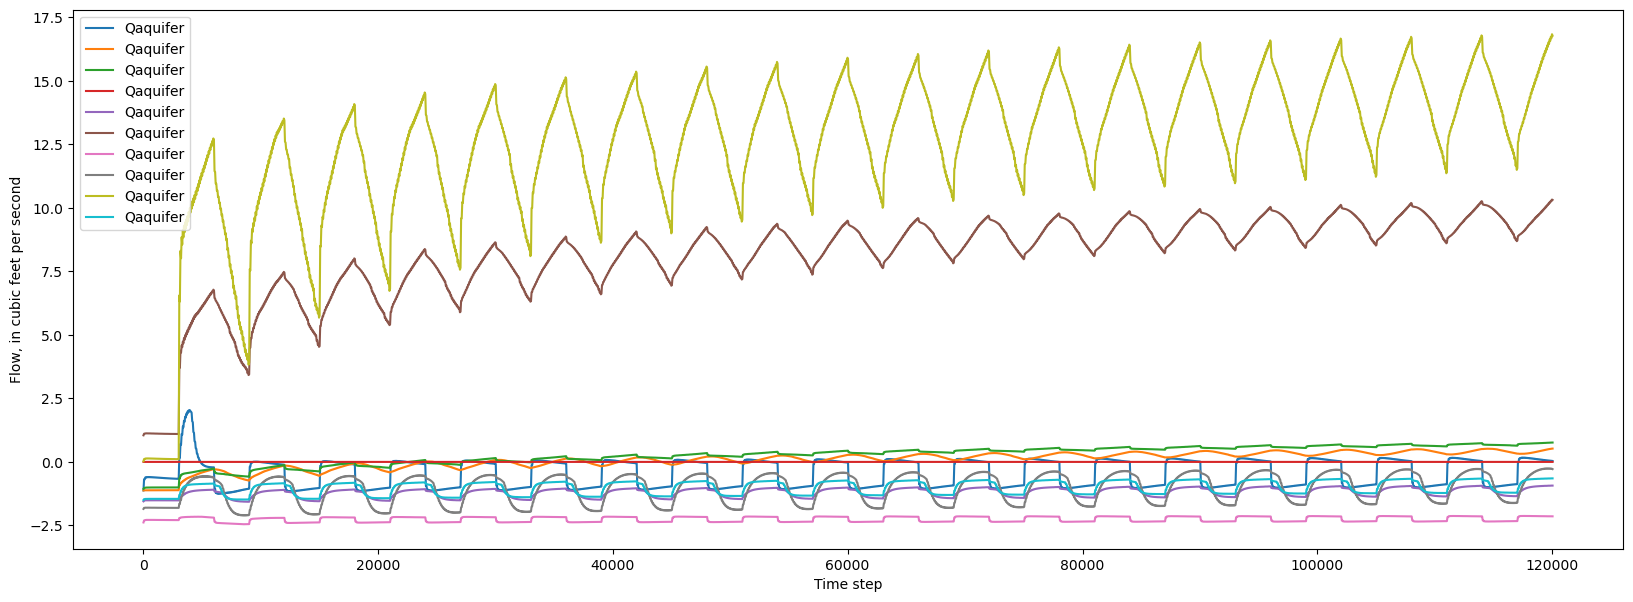

In [19]:
#Look at the variation in Q aquifer for the 5 random sampled simulations

for i in n3[:10]:
    modelname = "ScenarioSfr750SeasonsTest_"+str(i)
    sfrout = SfrFile(modws+'/'+modelname+'.sfr.out')
    df = sfrout.get_dataframe()
    df.reset_index(drop = True, inplace = True)
     #grab indices for reach of interest
#print(df.reach[inds].astype(str))
    inds = df.reach == 32
    if i == n3[0]:
        ax = df.loc[inds, ["Qaquifer"]].plot(figsize = (20,7))
    else:
        df.loc[inds, ["Qaquifer"]].plot(figsize = (20,7), ax =ax)
    
ax.set_ylabel("Flow, in cubic feet per second")
ax.set_xlabel("Time step");



In [53]:
col_names = ['K', 'Low_K_ratio', 'Sy', 'Rech', 'ET_valley', 'ET_rip_ratio', 'Stream_K_ratio']
pd.DataFrame(sampling[n[:5]], columns = col_names).head(5)

,K,Low_K_ratio,Sy,Rech,ET_valley,ET_rip_ratio,Stream_K_ratio
0,0.034612,0.001155,0.151135,0.000022,0.000004,4.223459,0.001448
1,0.075289,0.000542,0.237767,0.000046,0.000005,6.191098,0.000529
2,0.022627,0.011371,0.204247,0.000024,0.000005,6.489352,0.004659
3,0.046207,0.000217,0.472853,0.000039,0.000002,7.601402,0.000132
4,0.018518,0.000373,0.433478,0.000039,0.000002,6.391771,0.005211


In [ ]:
#modelname = "ScenarioSfr750Seasons_"+str(i)
headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
#head = headobj.get_alldata(nodata=-9.9998999e+02)
head = headobj.get_ts([(0,21,32)])
print(head)
head[:,0] = (head[:,0] / 6) * 50 #go from total time to the reach (50) period (6) times in the SFR file

plt.figure(figsize = (20,7))
plt.plot(head[:,0],head[:,1])


## Saving the output for each run 

In [16]:

#get rid of the simulations that return an error and save the outputs

#first get the simulations from teh Steady Pump (drawdown) runs - re doing this from above as I overwrote n2
error_list_SP = np.loadtxt('ErrorSteadyPump_Sfr750Test.txt')
sampling = np.loadtxt("ModflowParams7-750Test12.txt")
n = np.arange(0,len(sampling))
n2 = np.setdiff1d(n, error_list_SP[:,0].astype('int'))

#Now get the most recent error list and remove those from n2
error_list_seasons = np.loadtxt("ErrorSeasons_Sfr750Test.txt")
#eidx = np.array(error_list)[:,0].astype(int)
n3 = np.setdiff1d(n2, error_list_seasons[:,0].astype('int'))

for k,i in enumerate(n3):
    modelname = "ScenarioSfr750SeasonsTest_"+str(i)
    sfrout = SfrFile(modws+'/'+modelname+'.sfr.out')
    df = sfrout.get_dataframe()
    #should be 50 rows for the first stress period (1 timestep for each reach), then 1500 (50*30) for the remaining 20 stressperiods for a total of 30050 timesteps (rows)
    df['Stp']= 1
    df.iloc[50:,-1] = (np.divmod(np.arange(len(df)-50),50*30*2)[0]+1)+1 #Stp is the last col (-1) so the iloc references every row beyond 50 in the last column
    df['simnum'] = i
    #group rows by change in Stp and grab the last Stress period 
    Stpdf = df.groupby('Stp').tail(n=50) #groups tthe dataframe by the Stress period then grabs the last 50 rows (reaches) of the stress period representing the last timestep
    Stpdf.reset_index(drop=True, inplace = True)
    if k == 0:
        savedf = Stpdf
    else:
        savedf = savedf.append(Stpdf) #apparently appending a dataframe is improper so this takes a minute

print(len(savedf))
savedf.to_csv('TransSeasonsOutputStpTest.csv')

861000


In [17]:
#Test 
newdf = pd.read_csv('TransSeasonsOutputStpTest.csv')
print(len(newdf.simnum.unique()))

420
